# Исследование данных сервиса аренды самокатов

В роли аналитика для популярного сервиса аренды самокатов GoFast, вам поручено исследовать данные, связанные с использованием сервиса в различных городах. Ваша задача — провести анализ и проверить несколько гипотез, что может способствовать росту бизнеса.

Пользователи GoFast совершают поездки по городу с помощью мобильного приложения, которое предоставляет два варианта использования:
- без подписки
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.

# Описание данных

В основных данных есть информация о пользователях, их поездках и подписках.

Пользователи — `users_go.csv`

| Переменная | описание |
| ---- | ---- |
| user_id | уникальный идентификатор пользователя |
| name | имя пользователя |
| age | возраст |
| city | город |
| subscription_type | тип подписки (free, ultra) |

Поездки — `rides_go.csv`

| Переменная | описание |
| ---- | ---- |
| user_id | уникальный идентификатор пользователя |
| distance | расстояние, которое пользователь проехал в текущей сессии (в метрах) |
| duration | продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку» |
| date | дата совершения поездки |

	
Подписки — `subscriptions_go.csv`

| Переменная | описание |
| ---- | ---- |
| subscription_type | тип подписки |
| minute_price | стоимость одной минуты поездки по данной подписке |
| start_ride_price | стоимость начала поездки |
| subscription_fee | стоимость ежемесячного платежа |

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import binom

#### Шаг 1. Загрузка данных

##### Считайте CSV-файлы с данными с помощью библиотеки pandas и сохраните их в датафреймы. Пути к файлам:
- ```/datasets/users_go.csv```
- ```/datasets/rides_go.csv```
- ```/datasets/subscriptions_go.csv```


##### Выведите первые строки каждого набора данных. Изучите общую информацию о каждом датафрейме.

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv', parse_dates=['date'], dayfirst=True)
subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

Выведем всю информацию о датафреймах в порядке информация о пользователях, о поездках и подписках соответственно

In [3]:
sns.set_theme()

Параллельно с этим еще рассмотрим количество пустых значений. Для вывода всей информации напишем функцию, которая будет выводить все необходимые данные, а так же рассмотрим первые 10 строчек каждого датафрейма

In [4]:
def histogramm_and_info(data: pd.DataFrame):
    print('Info about data:')
    data.info()
    print('\nInfo about missing data:\n', data.isna().sum())

In [5]:
histogramm_and_info(users)

Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB

Info about missing data:
 user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64


In [6]:
users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [7]:
histogramm_and_info(rides)

Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB

Info about missing data:
 user_id     0
distance    0
duration    0
date        0
dtype: int64


In [8]:
rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [9]:
histogramm_and_info(subscriptions)

Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes

Info about missing data:
 subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


In [10]:
subscriptions.head(10)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


После первичного анализа с датафремами мы можем сделать следующие выводы:
- имеется три датафрема
    - ``users`` - в котором хранится персональная информация о пользователях
    - ``rides`` - в котором хранится информация о всех поездках, где пользователь идентифицирован через `user_id`
    - ``subscriptions`` - в нем хранится информация о стоимости минуты поездки, старта начала и подписки в зависимости от типа подписки. Связан с `users` через ключ `subscription_type`
- датафремы имеют разное количество строк, поскольку хранят различные области данных

#### Шаг 2. Предобработка данных

##### Приведите столбец ```date``` к типу даты pandas.
##### Создайте новый столбец с номером месяца на основе столбца ```date```.
##### Проверьте наличие пропущенных значений и дубликатов в датафреймах. Обработайте их, если такие значения присутствуют.

Для приведения типа данных столбца `date` из датафрейма `rides` к соответствующему типу данных мы воспользовались параметрами `parse_dates=['date'], dayfirst=True` для правильного форматирования при изначальной загрузке датафрейма

In [11]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [12]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


Как мы видим, формат для столбца `date` - datatime64[ns]. Это подходящий для дат формат. Теперь создадим стоблец, в котором будут храниться данные с номером месяца поездки.

In [13]:
rides['month'] = pd.DatetimeIndex(rides['date']).month

Удостоверимся, что добавление столбца произошло корректно и выведем первые 10 строчек датафрема, а также рассмотрим какие месяцы и годы имеются в датафрейме `rides`

In [14]:
sorted(rides['month'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [15]:
pd.DatetimeIndex(rides['date']).year.unique()

Int64Index([2021], dtype='int64', name='date')

В датафреме присутствуют данные за 2021 год, которые включают в себя все месяцы

In [16]:
rides.head(10)

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
5,1,2770.890808,16.650138,2021-10-09,10
6,1,3039.020292,14.927879,2021-10-19,10
7,1,2842.118050,23.117468,2021-11-06,11
8,1,3412.690668,15.238072,2021-11-14,11
9,1,748.690645,15.041884,2021-11-22,11


Для каждого датафрейма уже проверили отсутствие пропусков, но еще раз проверим их отсутствие и проверим наличие дубликатов в датафремах при помощи функции.

In [17]:
def duplicates_nulls(data: pd.DataFrame):
    print('Info about missing data:\n', data.isna().sum())
    duplicated_data = int(data.duplicated().sum())
    print('\nInfo about duplicates:\n', duplicated_data)
    if duplicated_data != 0:
        percent = duplicated_data / len(data)
        print(f'Percent of duplicated data is {round(percent * 100, 2)}%')
    print()

Проверка для датафреймов `rides`, `users`, `subscriptions`

In [18]:
dataframes = {'rides': rides, 'users': users, 'subscriptions': subscriptions}
for data_name, data in dataframes.items():
    print(f'Info about {data_name}')
    duplicates_nulls(data)

Info about rides
Info about missing data:
 user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

Info about duplicates:
 0

Info about users
Info about missing data:
 user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

Info about duplicates:
 31
Percent of duplicated data is 1.98%

Info about subscriptions
Info about missing data:
 subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Info about duplicates:
 0



Проверка для датафрейма `users` показала наличие 31 дупликата, однако процент данных от общего количества мал, поэтому мы можем спокойно от них избавиться

In [19]:
users = users.drop_duplicates().reset_index(drop=True)

In [20]:
users.duplicated().sum()

0

Вывод:
- было проверено наличие пропусков, которые отстутствуют во всех датафреймах
- было проверено наличие дубликатов, которые обнаружены в датафрейме `users` в количестве 31 штуки, однако процент дубликатов от общего количества данных в `users` составил 2%, поэтому повторяющиеся строки были удалены
- в датафреме `rides` присутствует дата поездки, что учитывалось при загрузке данных в начале. Было проанализированно, что `rides` содержит в себе данные за 2021 год за каждый месяц

#### Шаг 3. Исследовательский анализ данных

Опишите и визуализируйте общую информацию о пользователях и поездках:
- частота встречаемости городов;
- соотношение пользователей с подпиской и без подписки;
- возраст пользователей;
- расстояние, которое пользователь преодолел за одну поездку;
- продолжительность поездок.

Для начала проанализируем частоту встречаемости городов. Для этого реализуем список уникальных значений и вычислим их процент от общего числа. Города у нас расположены в датафрейме `users` в столбце `city`

In [21]:
city_freq = (users['city'].value_counts()).to_frame()
city_freq.columns = ['number_of_users']
city_freq['city'] = city_freq.index
city_freq = city_freq.reset_index(drop=True)
city_freq

,number_of_users,city
0,219,Пятигорск
1,204,Екатеринбург
2,198,Ростов-на-Дону
3,193,Краснодар
4,189,Сочи
5,183,Омск
6,180,Тюмень
7,168,Москва


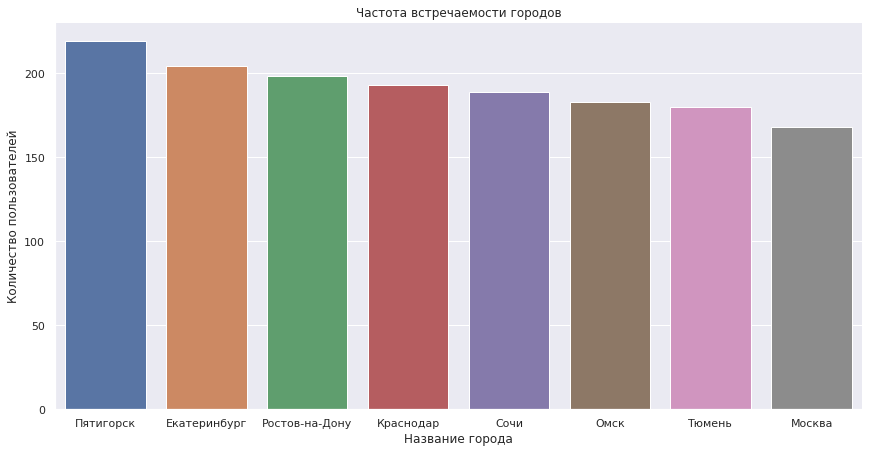

In [22]:
sns.catplot(data=city_freq, x='city', y='number_of_users', height=6, aspect=2, kind='bar');
plt.title('Частота встречаемости городов')
plt.xlabel("Название города")
plt.ylabel("Количество пользователей")
plt.show()

Теперь необходимо рассчитать соотношение пользователей с подпиской и без подписки. Для этого нам необходимо рассчитать количество пользователей с подпиской и без нее, а далее вычислить как они относятся друг к другу. Для начала рассмотрим какие вообще значения содержаться в столбце `subscription_type` в датафрейме `users`

In [23]:
users['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

Есть два значения в стоблце - `ultra` и `free`, отвечающие для наличие подписки и ее отсутствие соответственно. Рассчитаем теперь отношение двух групп пользователей друг к другу и какую часть они занимают от общего числа пользователей.

In [24]:
subscription_values = users['subscription_type'].value_counts().to_frame()
subscription_values.columns = ['count']
subscription_values['part'] = subscription_values['count'] / len(users['subscription_type'])
subscription_values

,count,part
free,835,0.544329
ultra,699,0.455671


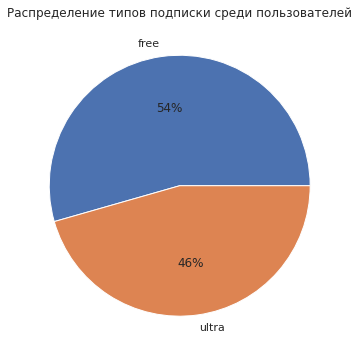

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.pie(subscription_values['part'], labels=subscription_values.index, autopct='%.0f%%', radius=1)
ax.set_title('Распределение типов подписки среди пользователей');

In [26]:
ratio = round(subscription_values.loc['free', 'count'] / subscription_values.loc['ultra', 'count'], 2)
ratio

1.19

При помощи круговой диаграммы можно легко отследить соотношение пользователей с подпиской и без нее. Так же было найдено отношение количества пользователей без подписки к пользователям с подпиской и это значение составляет 1,19

Рассмотрим возраст пользователей. Для этого построим диаграмму распределения по возрастам

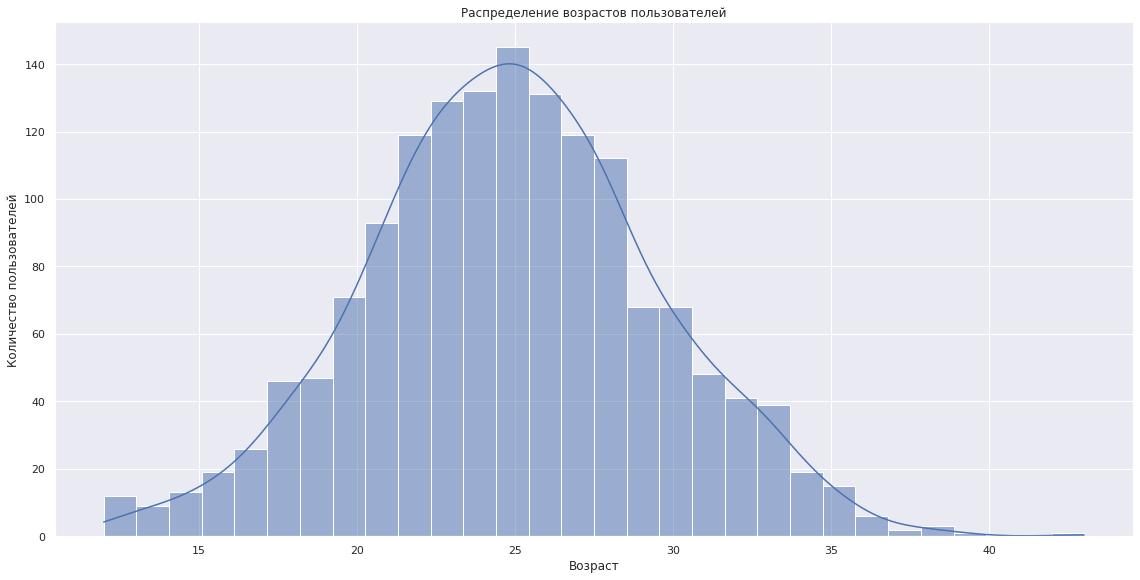

In [27]:
sns.displot(users['age'], kde=True, height=8, aspect=2);
plt.title('Распределение возрастов пользователей');
plt.xlabel("Возраст")
plt.ylabel("Количество пользователей")
plt.show()

Данное распределение очень похоже на нормальное, наибольшее количество пользователей среди молодого поколения - макимум пользователей наблюдается среди людей 25 лет. Однако сервисом не пользуются люди старше 40 и младше 13 лет. Целевая аудитория находится в диапазоне 13 - 40 лет.

Теперь необходимо рассчитать расстояние, которое пользователь преодолел за одну поездку. Для этого оценим среднее расстояние и медианное расстояние для всех пользователей, а затем произведем группировку по конкретным пользователям.

In [28]:
distance_avg = round(rides['distance'].mean(), 2)
distance_avg

3070.66

In [29]:
distance_median = round(rides['distance'].median(), 2)
distance_median

3133.61

In [30]:
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

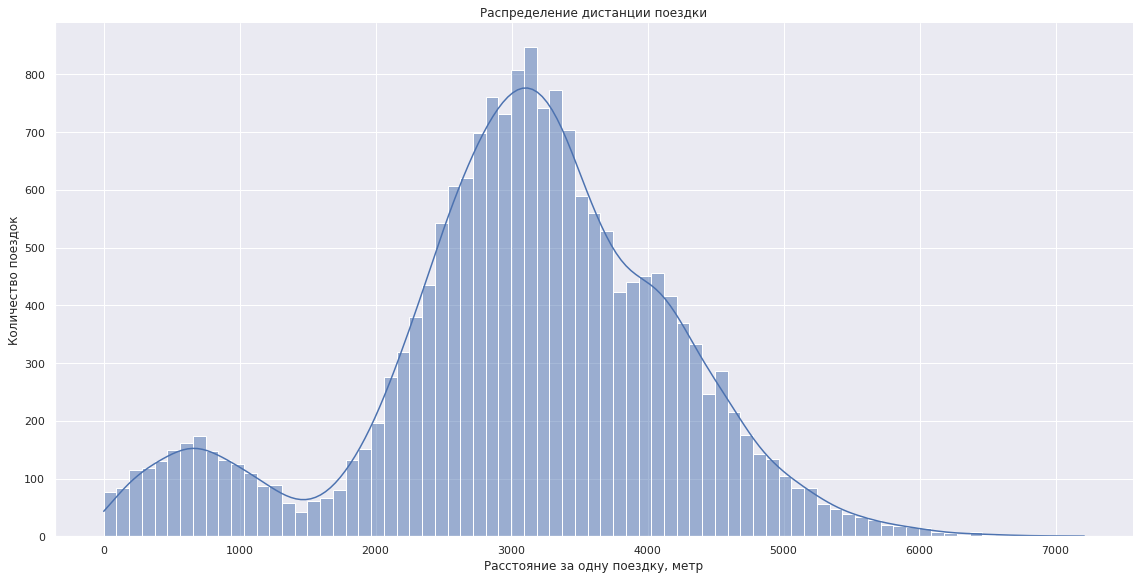

In [31]:
sns.displot(rides['distance'], kde=True, height=8, aspect=2);
plt.title('Распределение дистанции поездки');
plt.xlabel('Расстояние за одну поездку, метр');
plt.ylabel('Количество поездок');

Средняя дистанция у пользователей 3070.66 метров, это значение близко к медианному значению, равному 3133.61 метров. Построив гистограмму распредления по длине дистанции у пользователей, мы действительно можем заметить, что они преодолевают в основном дистанцию в 3100 метров.

Рассмотрим какая средняя продолжительность поездок для пользователей и так же построим диаграмму распределение среднего времени поездки у каждого пользователя.

In [32]:
duration_avg = round(rides['duration'].mean(), 2)
duration_avg

17.81

In [33]:
duration_median = round(rides['duration'].median(), 2)
duration_median

17.68

In [34]:
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

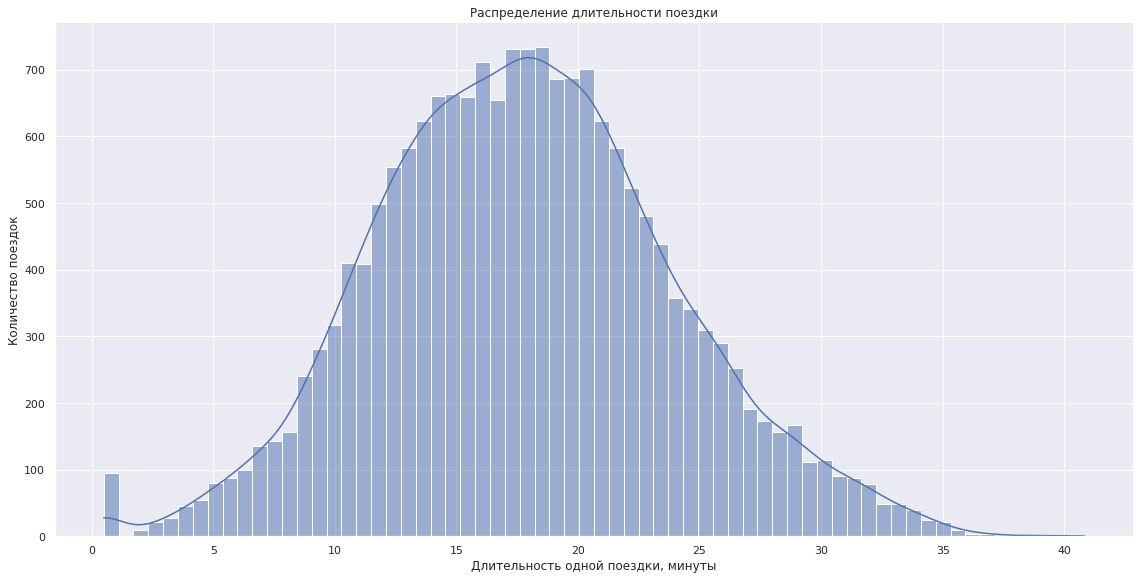

In [35]:
sns.displot(rides['duration'], kde=True, height=8, aspect=2);
plt.title('Распределение длительности поездки');
plt.xlabel('Длительность одной поездки, минуты');
plt.ylabel('Количество поездок');

Средняя длительность поездки у пользователей 17.81 минут, это значение близко к медианному значению, равному 17.68 минут. Построив гистограмму распредления по длительности поездки у пользователей, мы действительно можем заметить, что большее количество пользователей тратят в основном 18 минут на поездку.

**Вывод**:
- Количество пользователей в городах находится в диапазоне от 168 до 220. Самый популярный город у сервиса это Пятигорск, тогда как самый непопулярный - Москва. Количество пользователей в городах друг от друга различаются не слишком сильно, а распределены довольно равномерно относительно друг друга
- В сервисе есть два типа подписки: платная и бесплатная. Количество пользователей без платной подписки больше в 1.19 раз, их количество составляет 835 пользователей, тогда как с подпиской ultra - 699. Пользователи с бесплатной подпиской составляют 54% от общего числа, а пользователи второй категории 46%
- Основные пользователи сервиса - молодые люди в восрасте от 13 до 40 лет. Большее количество пользователей имеют возраст в районе 25 лет и распределение возрастов похоже на нормальное распределение
- Средняя дистанция у пользователей 3070.66 метров, это значение близко к медианному значению, равному 3133.61 метров. Построив гистограмму распредления по длине дистанции у пользователей, мы можем заметить, что эти значения различаются из-за небольшого пика в районе 800 метров. Однако мксимальный пик достигается около 3100 метров
- Средняя длительность поездки у пользователей 17.81 минут, это значение близко к медианному значению, равному 17.68 минут. Построив гистограмму распредления по длительности поездки у пользователей, мы действительно можем заметить, что большее количество пользователей тратят в около 18 минут на поездку. Распредение имеет нормальную форму с небольшим выбросом в районе нуля.

#### Шаг 4. Объединение данных

##### Объедините данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуйтесь методом merge().
##### Создайте ещё два датафрейма из датафрейма, созданного на этапе 4.1:
- c данными о пользователях без подписки;
- с данными о пользователях с подпиской.

##### Визуализируйте информацию о расстоянии и времени поездок для пользователей обеих категорий.

In [36]:
data = users.merge(rides, on='user_id').merge(subscriptions, on='subscription_type')

In [37]:
if len(rides) == len(data):
    print('Объединение произошло без потерь или дубликатов')
else:
    print('При объединении произошла ошибка')

Объединение произошло без потерь или дубликатов


In [38]:
len(data)

18068

Создадим датафрейм с пользователями имеющими платную подписку

In [39]:
data_with_sub = data.query('subscription_type == "ultra"')

И так же создадим датафрейм с пользователями, пользующимися сервисом бесплатно

In [40]:
data_without_sub = data.query('subscription_type == "free"')

Проделаем те же операции, что и для этого: посчитаем среднее, медиану, а также постоим диаграмму распределение. Для удобства реализацию выполним при помощи функции

In [41]:
def data_info(parametr: str, data: pd.DataFrame, info: str):
    print(f'Info about: {info}')
    print(f'Mean of {parametr} is {round(data[parametr].mean(), 2)}')
    print(f'Median of {parametr} is {round(data[parametr].median(), 2)}')
    print(data[parametr].describe())

In [42]:
data_info('distance', data_without_sub, 'Users without subscription')

Info about: Users without subscription
Mean of distance is 3045.5
Median of distance is 3114.65
count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64


In [43]:
data_info('distance', data_with_sub, 'Users with subscription')

Info about: Users with subscription
Mean of distance is 3115.45
Median of distance is 3148.64
count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64


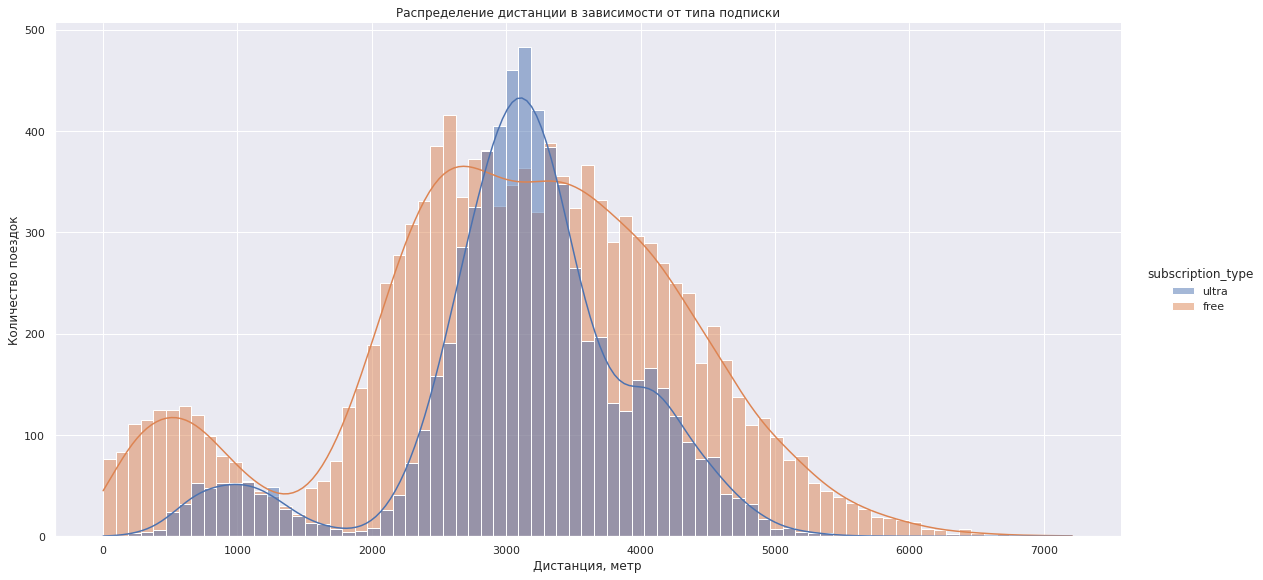

In [44]:
sns.displot(data, x='distance', hue='subscription_type', kde=True, height=8, aspect=2);
plt.title('Распределение дистанции в зависимости от типа подписки');
plt.ylabel('Количество поездок');
plt.xlabel('Дистанция, метр');

Пользователи без подписки совершают большее количество поездок по сравнению с пользователями с подпиской `ultra`. Для пользователей с подпиской `ultra` распределение похоже на нормальное, имеется выброс в районе 1000 метров и 4100 метров. Для пользователец без подписки нет настолько яркого максимума, однако среднее и медианное значение не сильно отмличаются от пользователй с подпиской и составляет 3045.5 и 3114.65 соответственно. Для пользователей с подпиской эти значения являются 3115.45 и 3148.64 для среднего и медианного значений соответственно.

In [45]:
data_info('duration', data_with_sub, 'Users with subscription')

Info about: Users with subscription
Mean of duration is 18.54
Median of duration is 18.18
count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64


In [46]:
data_info('duration', data_without_sub, 'Users without subscription')

Info about: Users without subscription
Mean of duration is 17.39
Median of duration is 17.33
count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64


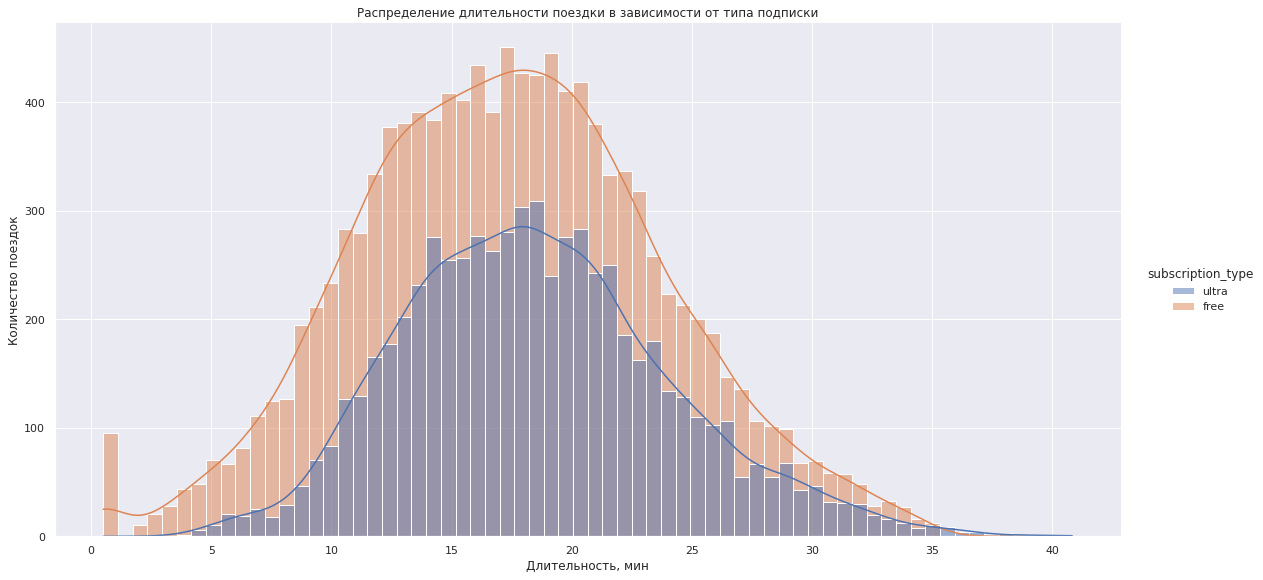

In [47]:
sns.displot(data, x='duration', hue='subscription_type', kde=True, height=8, aspect=2);
plt.title('Распределение длительности поездки в зависимости от типа подписки');
plt.ylabel('Количество поездок');
plt.xlabel('Длительность, мин');

На распределении длительности поездок так же отчетливо видно, что поездок без подкписки совершается больше, чем поездок с подпиской. По форме оба распределения напоминают нормальное распределение, однако для бесплатных подписок заметен выброс в районе нуля - 1 минуты поездки. Средние и медианные значения для пользователей без подписки и с подпиской составляют 17.39 и 17.33 минуты и 18.54 и 18.18 минут.

То есть разница между длительностью около 1 минуты для среднего и медианного значений.

**Вывод**

Оценивая полученнные результаты, можно сделать вывод, что люди с подпиской совершают более длительнеы и дальние поездки, в отличие от пользователей без нее. Однако средние значения отличаются друг от друга не так сильно для этих групп пользователй. Так же пользователи с подпиской совершают примерно в два раза больше поездок, чем пользователи с бесплатной подпиской.

#### Шаг 5. Подсчёт выручки

##### Создайте датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдите суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.


In [48]:
data['duration'] = np.ceil(data['duration'])

In [49]:
data_agg = data.groupby(['user_id', 'month']).agg({'distance': ['sum', 'count'], 
                                                   'duration': 'sum'}).reset_index()
data_agg.columns = ['user_id', 'month', 'distance_sum', 'count_rides', 'duration_sum']
data_agg.head()

,user_id,month,distance_sum,count_rides,duration_sum
0,1,1,7027.511294,2,42.0
1,1,4,754.159807,1,7.0
2,1,8,6723.470560,2,46.0
3,1,10,5809.911100,2,32.0
4,1,11,7003.499363,3,56.0


##### В этот же датафрейм добавьте столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратитесь к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округляется до следующего целого числа: например, значения 25.3, 25.5 и 26.0 должны быть преобразованы к 26.

In [50]:
len(data_agg)

11331

Добавим так же столбец `revenue` с выручкой, который принес каждый пользователь, для этого добавим тип подписки для каждого пользователя в датафрейме `data_prices` 

In [51]:
data_prices = data_agg.merge(users[['user_id', 'subscription_type']], on='user_id', how='inner')
data_prices = data_prices.merge(subscriptions[['subscription_type', 'minute_price', 'start_ride_price', 'subscription_fee']],
                               on='subscription_type', how='inner')

In [52]:
len(data_prices)

11331

Для рассчета выручки используем данные о расценках в зависимости от подписки из таблицы `subscriptions`

In [53]:
data_prices['revenue'] = (data_prices['minute_price'] * data_prices['duration_sum'] 
                          + data_prices['start_ride_price'] * data_prices['count_rides'] 
                          + data_prices['subscription_fee'])

In [54]:
data_prices.head()

,user_id,month,distance_sum,count_rides,duration_sum,subscription_type,minute_price,start_ride_price,subscription_fee,revenue
0,1,1,7027.511294,2,42.0,ultra,6,0,199,451.0
1,1,4,754.159807,1,7.0,ultra,6,0,199,241.0
2,1,8,6723.470560,2,46.0,ultra,6,0,199,475.0
3,1,10,5809.911100,2,32.0,ultra,6,0,199,391.0
4,1,11,7003.499363,3,56.0,ultra,6,0,199,535.0


**Вывод**

В данном месте было произведено агрегированние суммарного расстояния, количества поездок и суммарной длительности для каждого пользователя в каждом месяце. Для рассчета выручки по пользователю было применено объединие датафремов и далее рассчет через арифметические действия. 

Данные готовы к проверке гипотез и статистическим тестам.

#### Шаг 6. Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.
##### Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Для начала проверим гипотезу о том, что пользователи с подпиской проводят больше времени в поездке. Тогда наша нулевая гипотеза звучит так 

- H_0: Пользователи с подпиской проводят одинаковое времени в поездке, что и пользователи без подписки. 

Альтернативная гипотеза будет звучать так 

- H_1: Пользователи  с подпиской проводят больше времени, чем пользователи без подписки.

Проведем тест с использованием гипотезы о равенстве двух генеральных совокупностей.

In [55]:
alpha = 0.05

result_theory_1 = st.ttest_ind(data_with_sub['duration'], data_without_sub['duration'], alternative='greater')
if result_theory_1.pvalue > alpha:
    print(f'Нулевая теория подтверждена')
else:
    print(f'Подтверждена альтернативная теория')

Подтверждена альтернативная теория


Соответственно мы получили результат, говорящий о том, что пользователи с подпиской проводят больше времени, чем пользователи без подписки

##### Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

Теперь проверим, является ли среднее расстояние для пользователей с подпиской меньше 3130 метров за одну поездку. Для этого сформулируем две гипотезы:

- Нулевая гипотеза Н_0: Среднее расстояние равно 3130 метров за одну поездку
- Альтернативная гипотеза Н_1: Среднее расстояние превышает 3130 метров за одну поездку

In [56]:
optimal_distance = 3130

result_theory_2 = st.ttest_1samp(data_with_sub['distance'], optimal_distance, alternative='greater')

if result_theory_2.pvalue > alpha:
    print('Нулевая теория подтверждена')
else:
    print('Подтверждена альтернативная теория')

Нулевая теория подтверждена


В итоге мы получили результат, что в среднем поездка для пользователей с подпиской равно или не превышает 3130 метров.

##### Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

Для проверки этой гипотезы разобьем созданый нам датафрейм с подсчетом выручки на два и при помощи гипотезы о равенстве двух генеральных совокупностей рассчитаем, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем от пользователей без подписки.

Для этого сформулируем нулевую и альтернативные теории:
- H_0: Помесячная выручка не зависит от вида подписки
- Н_1: Помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки

In [57]:
result_theory_3 = st.ttest_ind(data_prices.query('subscription_type == "ultra"')['revenue'], 
                               data_prices.query('subscription_type == "free"')['revenue'], 
                               alternative='greater')

if result_theory_3.pvalue > alpha:
    print('Нулевая теория подтверждена')
else:
    print('Подтверждена альтернативная теория')

Подтверждена альтернативная теория


В итоге мы получили результат, что помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки

##### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Гипотеза о равенстве средних для зависимых (парных) выборок

При помощи `st.ttest_rel`

**Вывод**:
На этом шаге было проверено 3 гипотезы:
- тратят ли пользователи с подпиской больше времени на поездки: Действительно, пользователи с подпиской тратят больше времени на поездки, чем пользователи с бесплатной подпиской
- среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров: Гипотеза подтвердилась - пользователи с подпиской проезжают 3130 или меньше метров за одну поездку
- будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки: да, помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки. Соответственно для сервиса более выгодны пользователи с подпиской, чем вторая категория пользователей

#### Шаг 7. Распределения

##### Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

In [58]:
n, x = 100, 100
p = 0.1
result = binom.cdf(x, n, p)

while result >= 0.05:
    result = binom.cdf(x, n, p)
    n += 1

In [59]:
distr = []
for k in range(0, n + 1):
    chance = binom.pmf(k, n, p)
    distr.append(chance)

/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:78: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


Вероятность не выполнить план 5.0% при количестве высланных промокодов 1173


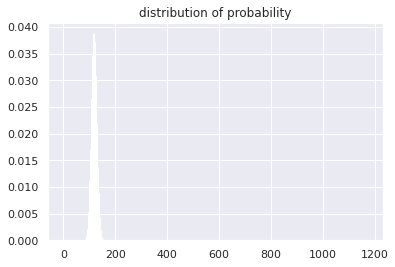

In [60]:
plt.bar(range(0, n + 1), distr)
plt.title('distribution of probability')
print(f'Вероятность не выполнить план {round(result * 100, 1)}% при количестве высланных промокодов {n}')

Соответственно отделу маркетинга нужно выслать от 1173 промокодов, чтобы выполнить план

##### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации постройте примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Эта ситуация тоже описывается биномиальным распределением. Но считать каждое отдельное значение достаточно долго. Вы можете воспользоваться нормальной аппроксимацией биномиального распределения и `cdf()` для быстрой оценки.

In [61]:
from math import sqrt

n = 10**6
p = 0.4

mu = n * p
sigma = sqrt(n * p * (1 - p))

distr_2 = st.norm(mu, sigma) 

result_2 = distr_2.cdf(399500)

In [62]:
print(f'Вероятность {round(result_2, 3)}, что уведомление откроют не более 399,5 тыс. пользователей.')

Вероятность 0.154, что уведомление откроют не более 399,5 тыс. пользователей.


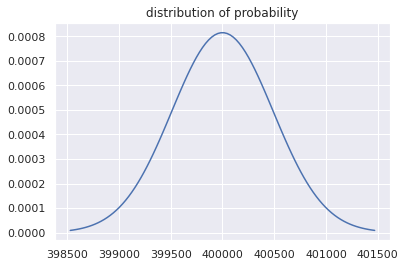

In [63]:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, st.norm.pdf(x, mu, sigma))
plt.title('distribution of probability');

Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей 15,4%.

**Итоговый вывод:**

В ходе проделанной работы было выполнено:
 - Предварительный анализ данных трех датафремов, подсчет пропусков и дубликатов данных. В результате в таблице rides былоудален 31 дубликат, составлявший 2 процента от общего числа поездок
 - Исследовательский анализ данных в ходе которого было выяснено:
     - Количество пользователей в городах находится в диапазоне от 168 до 220. Самый популярный город у сервиса это Пятигорск, тогда как самый непопулярный - Москва. Количество пользователей в городах друг от друга различаются не слишком сильно, а распределены довольно равномерно относительно друг друга
    - В сервисе есть два типа подписки: платная и бесплатная. Количество пользователей без платной подписки больше в 1.19 раз, их количество составляет 835 пользователей, тогда как с подпиской ultra - 699. Пользователи с бесплатной подпиской составляют 54% от общего числа, а пользователи второй категории 46%
    - Основные пользователи сервиса - молодые люди в восрасте от 13 до 40 лет. Большее количество пользователей имеют возраст в районе 25 лет и распределение возрастов похоже на нормальное распределение
    - Средняя дистанция у пользователей 3070.66 метров, это значение близко к медианному значению, равному 3133.61 метров. Построив гистограмму распредления по длине дистанции у пользователей, мы можем заметить, что эти значения различаются из-за небольшого пика в районе 800 метров. Однако мксимальный пик достигается около 3100 метров
    - Средняя длительность поездки у пользователей 17.81 минут, это значение близко к медианному значению, равному 17.68 минут. Построив гистограмму распредления по длительности поездки у пользователей, мы действительно можем заметить, что большее количество пользователей тратят в около 18 минут на поездку. Распредение имеет нормальную форму с небольшим выбросом в районе нуля.
 - Была создана таблица с агрегированными данными, объединенная по пользователям и месяцам, куда были добавлены данные о подписках пользователей и полученной выгоды
 - Было проверено три гипотезы и получены по ним результаты:
     - тратят ли пользователи с подпиской больше времени на поездки: Действительно, пользователи с подпиской тратят больше времени на поездки, чем пользователи с бесплатной подпиской
    - среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров: Гипотеза подтвердилась - пользователи с подпиской проезжают 3130 или меньше метров за одну поездку
    - будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки: да, помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки. Соответственно для сервиса более выгодны пользователи с подпиской, чем вторая категория пользователей
  - Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку - для этого необходимо разослать от 1137 промокодов
  - Для push-уведомлений вероятность того, что уведомление откроют не более 399,5 тыс. пользователей 15,4% при отправке 1 млн уведомлений.
  
 **Итоговый вывод**
 - Пользователи с подпиской тратят больше времени в поездках, но это значение не сильно отличается от пользователей без подписки. Однако пользователи с подпиской будут более выгодны для компании за счет того, что статистически они приносят больше выручки помесячно.
 - Пользователи с подпиской более выгодны за счет того, что они проездают меньше или равное оптимальное расстояние для предотвращения износа самоката

**Рекомендации:**
 - Возможно стоит изменить способ хранения данных о стоимости подписки - в таблице хранятся нули там, где должны хранится пустые значения. 
 - Вероятно стоит увеличить вариации подписок -тем самым дать больше вариантов оплаты для пользователей и как следствие увеличить выручку